# Modelling Notebook

## Basic SEIR Model

In [1]:
dS=expression(mu-(beta*I+mu)*S)
dE=expression(beta*S*I-(sigma+mu)*E)
dI=expression(sigma*E-(alpha+mu+lamda)*I)
dR=expression(lamda*I-mu*R)

Modified from Bjornstad (2018) and Keeling and Rohani (2007).
the models are slightly different, particularly in the meaning of S, E, I and R.
Here, they are proportions of the population (Keeling and Rohani).
Other parameters should be equivalent between models.
mu is the natural birth and death rate (assumed to be equal)
beta is the transmission rate
lamda is the recovery rate (reciprical of infectious period)
sigma is the rate of movement from E to I (reciprical of latent period)
alpha is rate of disease induced mortality


There is an option to make this more complex (i.e include hospitalisation and asymptomatic) which would make it more accurate (particularly in the distribution of the infectious period) but I don't think would improve understanding of the processes relevant to this project. 


In [2]:
model<-function(time,values,parms){
    S<-values[1]
    E<-values[2]
    I<-values[3]
    R<-values[4]
    beta<-parms["beta"]
    mu<-parms["mu"]
    sigma<-parms["sigma"]
    alpha<-parms["alpha"]
    lamda<-parms["lamda"]
    dS=mu-(beta*I+mu)*S
    dE=beta*S*I-(sigma+mu)*E
    dI=sigma*E-(alpha+mu+lamda)*I
    dR=lamda*I-mu*R
    list(c(dS,dE,dI,dR))
}

In [3]:
time = seq(0, 50, by = 1/10) 
#parameters from bjornstad book and guesses- just to test functions work!
parms = c(mu = 0, sigma=0.25 ,alpha=0.005, beta = 2, lamda = 1/2) 
start = c(S = 0.999, E=0.001,I = 0.00, R = 0)



In [4]:
plottime<-function(start,time,model,parms){
    require("epimdr")
    out=ode(y=start, time=time, func=model, parms= parms)
    plot(x=out[,"time"], y=out[,"S"], ylab="Fraction", xlab= "Time", type="l",ylim=c(0,1))
    lines(x=out[,"time"], y=out[,"E"], col="orange") 
    lines(x=out[,"time"], y=out[,"I"], col="red") 
    lines(x=out[,"time"], y=out[,"R"], col="green") 
    legend(0,0.2,legend=c("S","E","I","R"),col=c("black","orange","red","green"),lty=1, cex=0.8)
}

Loading required package: epimdr
Loading required package: shiny
Loading required package: deSolve
Loading required package: polspline


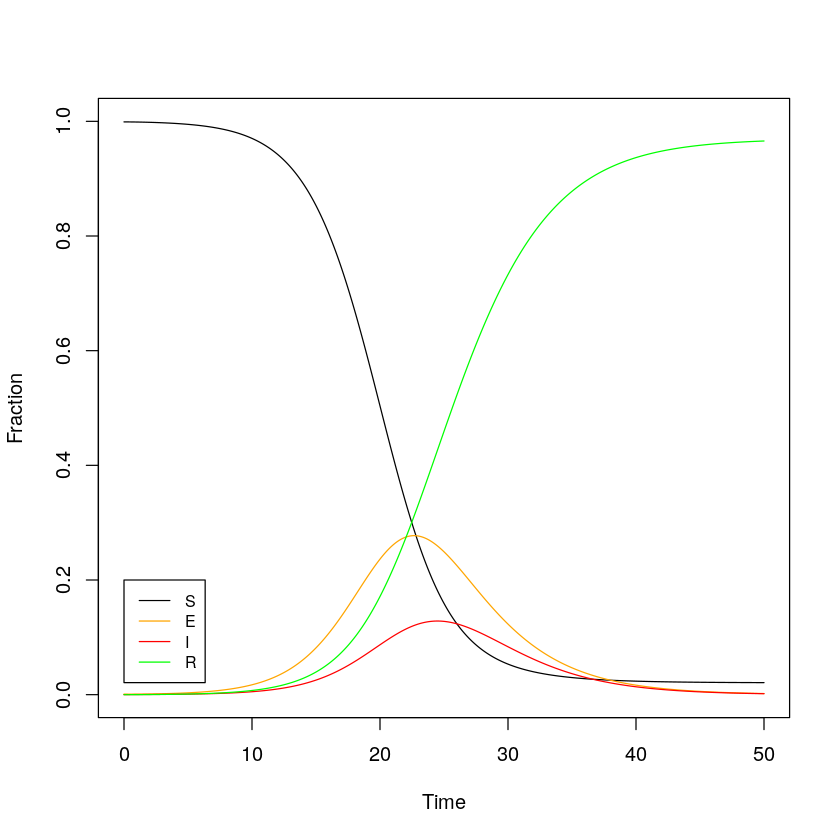

In [5]:
plottime(start,time,model,parms)

## Addition of Infection Control Measures


I am interested in understanding how these interact with climate variables.

more reading needed in this

### Social Distancing


Neher et al 2020 varied an dI/dt in a SIR model beta*S*I with a Hill function:

In [6]:
dI=expression((1-H)*beta*S*I-(mu + lamda)*E)
H=expression(c*(I^3/(k^3+I^3)))


I could add a similar modifier to the dE/dt part of my model. However could be easier to reduce contact rates by a percentage. i.e:

In [7]:
dE=expression(contact*beta*S*I-(sigma+mu)*E)


In [18]:
time = seq(0, 50,by = 1/10) 
#parameters from bjornstad book and guesses- just to test functions work!
parmscontact = c(mu = 0, sigma=0.25 ,alpha=0.005, beta = 2, lamda = 1/2,contact=0.7)
start = c(S = 0.999, E=0.001,I = 0.00, R = 0)
modelcontact<-function(time,values,parms){
    S<-values[1]
    E<-values[2]
    I<-values[3]
    R<-values[4]
    beta<-parms["beta"]
    mu<-parms["mu"]
    sigma<-parms["sigma"]
    alpha<-parms["alpha"]
    lamda<-parms["lamda"]
    contact<-parms["contact"]
    dS=mu-(contact*beta*I+mu)*S
    dE=contact*beta*S*I-(sigma+mu)*E
    dI=sigma*E-(alpha+mu+lamda)*I
    dR=lamda*I-mu*R
    list(c(dS,dE,dI,dR))
}

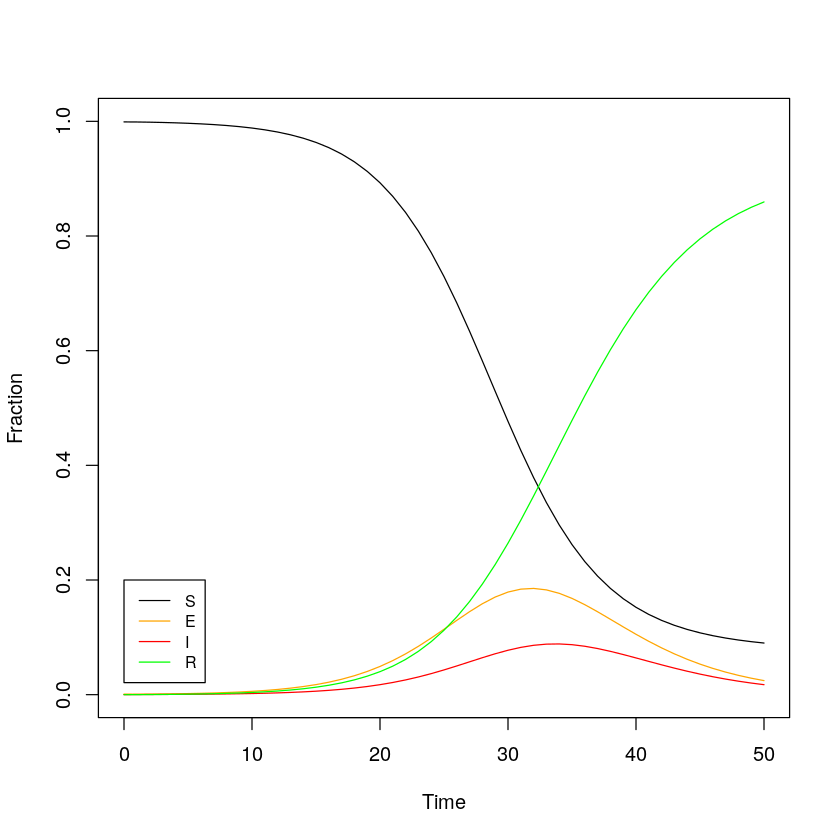

In [17]:
plottime(time=time,parms=parmscontact,start=start,model=modelcontact)

where contact is the percentage of the original contact rate.
This makes mechanistic sense because when kappa is the average number of contacts per unit time and c is the probability of successful transmission following a contact (chapter 2 keeling and rohani) :

In [10]:
beta=expression(-kappa*log(1-c))

if the number of contacts per unit time was halved (for example):

In [11]:
beta=expression(-(kappa*0.5)*log(1-c))
beta=expression(0.5*(-kappa*log(1-c)))
beta=expression(0.5*beta)

thoughts on trying to vary contact rate-run ode multiple times, each one starts at end values of one before, use different contact in parms

### Isolation of Infected


Could introduce a quarantine class to my SEIR model (Chapter 8, Keeling and Rohani 2007)

parameters needed-average time in isolation , rate of detection of infectious individuals

## Age structure and Transmission

Would need to have compartments for each age group, and quantify how much contact exists between groups (using polymod study). So dE for each is the sum of S*B*(sum of I from each group multiplied by how much contact there is) 

I think this could be really interesting but is unlikely to be very helpful for answering my question! So leave for now.

## Climate

###  Beta


#### Survivability %

Beta will change with humidity and temperature (seperate function beta=survivability * Maxbeta)
Maxbeta will be the maximum transmission rate (i.e if climate optimum). survivability is the percentage of the maximum transmission.
Not sure how to find Maxbeta
May need to think more about virology here.

Survivability(temperature,humidity)= ???

Coronavirus studies have looked at virus titre over time for different times and humidity combinations. Somehow convert these into a smooth 3d function (temperature, humidity, survival), maybe at an arbitrary point in time (1 hour?).
or maybe as a percent of maximum in the study. 
Other work has used a look up table with vapor pressure and transmission rate (Brenner 2017) and a function finding beta from lower and higher values of vapor pressure and corresponding transmission rates. The data used for this was experiments on transmission of influenza between guinea pigs. However actually transmission rate data does not seem to be available for coronaviruses
need to research available data (as more recent may be available

#### Beta expression attempt

considered breaking down beta but I think finding kappa and c is unlikely

In [12]:
beta=expression(-kappa*log(1-c))

c- the probably of infection following a contact- is what would be modified by climate (in lower temperatures, would be higher)
if c is reduced by 25% (not sure can use this without knowing c and kappa)

In [13]:
beta=expression(-kappa*log(1-0.75*c))


1-c- the probably of escaping infection following a contact- is what would be modified by climate (in lower temperatures, would be lower)
if 1-c is increased by 25%, (not sure can use this without knowing c and kappa)

In [14]:
beta=expression(-kappa*log(1.25*(1-c)))

### Within differences

Exploring effect of change in temperature/humidity over time.
The model may need to be discretised? then different survivabiity at each timepoint (from average climate data)

### Between differences- Spatial Component? 

Simple option- just do for regions with different climates
more complex- Potential to make a network to explore effect of movement of people between regions with different climate (Brenner 2017). 

### Climate and Behaviour 

Would need to modify constant for beta to be a function of how much people are socialising- indoors vs outdoors. This is very messy and would need a lot of data (which I don't think we have)

## Proposed model

In [15]:
dS=expression(mu-(contact*beta*I+mu)*S)
dE=expression(contact*beta*S*I-(sigma+mu)*E)
dI=expression(sigma*E-(alpha+mu+lamda)*I)
dR=expression(lamda*I-mu*R)

